In [1]:
import os
from dotenv import load_dotenv
from unstructured.partition.pdf import partition_pdf
from IPython.display import Image, display
import base64
from tqdm import tqdm
import hashlib
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.documents import Document
import uuid
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# For audio processing: Cần cài đặt:  pip install "transformers[torch]" 
from transformers import pipeline
import torch

# For Rerank processing: Cần cài đặt: pip install cohere
# import cohere
# from langchain_cohere import CohereRerank

In [2]:
# --- Thiết lập API Keys ---
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Nếu bạn muốn theo dõi LangChain (tùy chọn)
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_API_KEY"] = "" # Nếu bạn có key LangChain Cloud

# --- Cấu hình đường dẫn ---
output_path = "./data"
extracted_data_dir = "./content_v3"

os.makedirs(output_path, exist_ok=True)
os.makedirs(extracted_data_dir, exist_ok=True)
text_output_dir = os.path.join(extracted_data_dir, "texts")
images_output_dir = os.path.join(extracted_data_dir, "images")
tables_output_dir = os.path.join(extracted_data_dir, "tables")
audio_transcripts_output_dir = os.path.join(extracted_data_dir, "audio_transcripts")

os.makedirs(text_output_dir, exist_ok=True)
os.makedirs(images_output_dir, exist_ok=True)
os.makedirs(tables_output_dir, exist_ok=True)
os.makedirs(audio_transcripts_output_dir, exist_ok=True)


In [3]:
# --- Quét và thu thập các file PDF và Audio (GIỮ NGUYÊN) ---
pdf_files = []
audio_files = []
for filename in os.listdir(output_path):
    file_full_path = os.path.join(output_path, filename)
    if os.path.isfile(file_full_path):
        if filename.lower().endswith(".pdf"):
            pdf_files.append(file_full_path)
        elif filename.lower().endswith((".mp3", ".wav", ".flac")):
            audio_files.append(file_full_path)

print(f"Tìm thấy {len(pdf_files)} file PDF và {len(audio_files)} file Audio trong '{output_path}'.")

Tìm thấy 1 file PDF và 2 file Audio trong './data'.


In [4]:
# Danh sách toàn cục để thu thập tất cả các phần tử đã xử lý
all_texts = []
all_tables = []
all_images = []
all_audio_transcripts = []

# --- Xử lý các file PDF (GIỮ NGUYÊN) ---
for pdf_file_path in pdf_files:
    print(f"\nĐang phân tích PDF: {os.path.basename(pdf_file_path)} với Unstructured...")
    try:
        chunks = partition_pdf(
            filename=pdf_file_path,
            infer_table_structure=True,
            strategy="hi_res",
            extract_image_block_to_payload=True,
            extract_image_block_types=["Image", "Table"],
            image_extraction_settings={"size": {"longest_edge": True}},
            chunking_strategy="by_title",
            max_characters=10000,
            combine_text_under_n_chars=2000,
            new_after_n_chars=6000,
        )
        print(f"Đã phân tích {len(chunks)} chunks từ PDF: {os.path.basename(pdf_file_path)}.")
        print(f"Các loại Element được trích xuất: {set([str(type(el)) for el in chunks])}")

        for i, chunk in enumerate(tqdm(chunks, desc=f"Phân loại và thu thập dữ liệu từ {os.path.basename(pdf_file_path)}")):
            if not hasattr(chunk.metadata, 'filename'):
                 chunk.metadata.filename = os.path.basename(pdf_file_path)

            if "Table" in str(type(chunk)):
                table_filename = f"table_{os.path.splitext(os.path.basename(pdf_file_path))[0]}_{i}.html"
                table_file_path = os.path.join(tables_output_dir, table_filename)

                if hasattr(chunk.metadata, 'text_as_html') and chunk.metadata.text_as_html:
                    with open(table_file_path, "w", encoding="utf-8") as f:
                        f.write(chunk.metadata.text_as_html)
                else:
                    with open(table_file_path, "w", encoding="utf-8") as f:
                        f.write(chunk.text)

                all_tables.append(chunk)

            elif "CompositeElement" in str(type(chunk)):
                text_filename = f"text_{os.path.splitext(os.path.basename(pdf_file_path))[0]}_{i}.txt"
                text_file_path = os.path.join(text_output_dir, text_filename)
                with open(text_file_path, "w", encoding="utf-8") as f:
                    f.write(chunk.text)

                all_texts.append(chunk)

                if hasattr(chunk.metadata, 'orig_elements') and chunk.metadata.orig_elements:
                    for el in chunk.metadata.orig_elements:
                        if "Image" in str(type(el)) and hasattr(el.metadata, 'image_base64'):
                            all_images.append(el.metadata.image_base64)

            elif "Image" in str(type(chunk)) and hasattr(chunk.metadata, 'image_base64'):
                all_images.append(chunk.metadata.image_base64)

    except Exception as e:
        print(f"Lỗi khi xử lý PDF '{pdf_file_path}': {e}")

# --- Lưu hình ảnh từ Base64 (từ PDF) (GIỮ NGUYÊN) ---
for idx, b64_string in enumerate(tqdm(all_images, desc="Lưu hình ảnh từ Base64")):
    try:
        image_data = base64.b64decode(b64_string)
        file_hash = hashlib.md5(image_data).hexdigest()
        image_filename = f"image_from_b64_{file_hash}.png"
        image_file_path = os.path.join(images_output_dir, image_filename)

        with open(image_file_path, "wb") as f:
            f.write(image_data)
    except Exception as e:
        print(f"Cảnh báo: Không thể giải mã hoặc lưu hình ảnh Base64 thứ {idx+1}: {e}")

print(f"Đã phân loại và thu thập: {len(all_texts)} đoạn văn bản, {len(all_tables)} bảng, {len(all_images)} hình ảnh (base64) từ các PDF.")


Đang phân tích PDF: DeepSort.pdf với Unstructured...


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Đã phân tích 12 chunks từ PDF: DeepSort.pdf.
Các loại Element được trích xuất: {"<class 'unstructured.documents.elements.CompositeElement'>"}


Lưu hình ảnh từ Base64: 100%|██████████| 6/6 [00:00<00:00, 1000.03it/s]

Đã phân loại và thu thập: 12 đoạn văn bản, 0 bảng, 6 hình ảnh (base64) từ các PDF.



Ví dụ về hình ảnh được trích xuất (Base64):


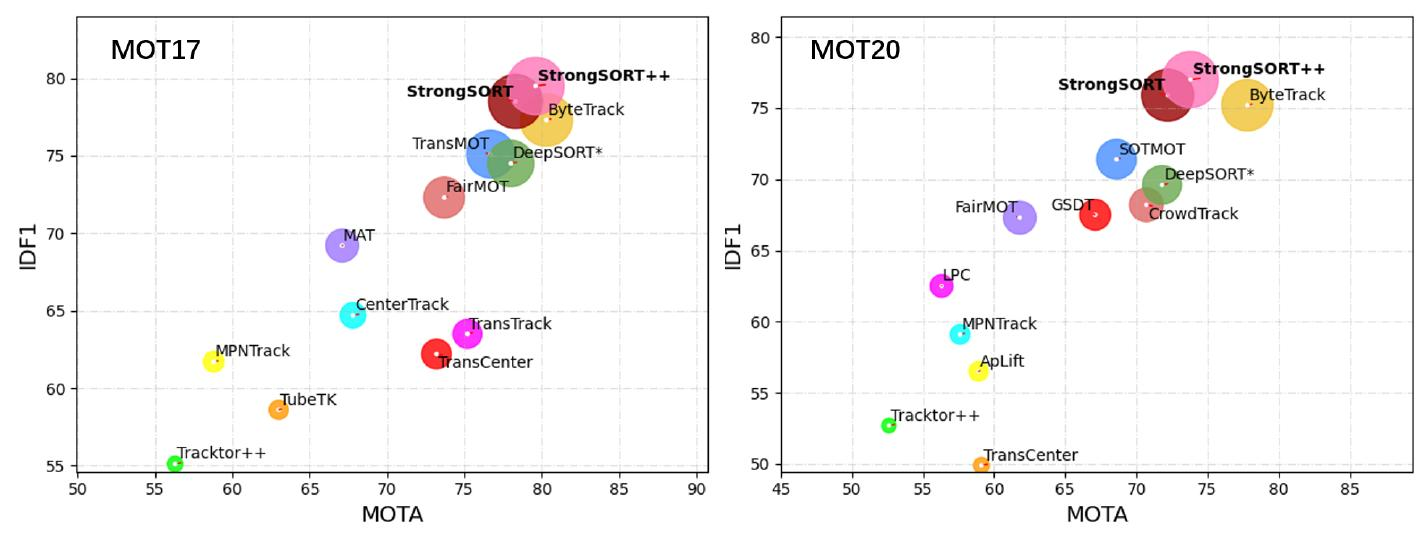

In [5]:
# Hàm tiện ích để hiển thị hình ảnh base64
def display_base64_image(base64_code):
    try:
        image_data = base64.b64decode(base64_code)
        display(Image(data=image_data))
    except Exception as e:
        print(f"Không thể hiển thị hình ảnh: {e}")

# Hiển thị một hình ảnh ví dụ (nếu có)
if all_images:
    print("\nVí dụ về hình ảnh được trích xuất (Base64):")
    display_base64_image(all_images[0])
else:
    print("\nKhông tìm thấy hình ảnh nào để hiển thị ví dụ.")

In [6]:
# --- Xử lý các file Audio ---
if audio_files:
    print("\nĐang khởi tạo mô hình Speech-to-Text (Whisper)...")
    device = 0 if torch.cuda.is_available() else -1

    asr_pipeline = pipeline(
        "automatic-speech-recognition",
        model="openai/whisper-tiny",
        device=device,
        chunk_length_s=30,
        return_timestamps=True
    )
    print(f"Mô hình Speech-to-Text đã sẵn sàng (chạy trên {'GPU' if device != -1 else 'CPU'}).")

    for audio_file_path in audio_files:
        print(f"Đang chuyển đổi giọng nói thành văn bản cho: {os.path.basename(audio_file_path)}...")
        try:
            transcription = asr_pipeline(audio_file_path)
            transcribed_text = transcription["text"]

            transcript_filename = f"{os.path.splitext(os.path.basename(audio_file_path))[0]}.txt"
            transcript_file_path = os.path.join(audio_transcripts_output_dir, transcript_filename)
            with open(transcript_file_path, "w", encoding="utf-8") as f:
                f.write(transcribed_text)

            audio_doc = Document(
                page_content=transcribed_text,
                metadata={
                    "filename": os.path.basename(audio_file_path),
                    "type": "audio_transcript"
                }
            )
            all_audio_transcripts.append(audio_doc)
            print(f"Đã chuyển đổi và lưu bản ghi cho {os.path.basename(audio_file_path)}.")
        except Exception as e:
            print(f"Lỗi khi xử lý file audio '{audio_file_path}': {e}")
else:
    print("\nKhông tìm thấy file audio nào để xử lý.")

print(f"\nTổng cộng đã thu thập: {len(all_texts)} đoạn văn bản (PDF), {len(all_tables)} bảng (PDF), {len(all_images)} hình ảnh (PDF), {len(all_audio_transcripts)} bản ghi âm.")
print(f"Dữ liệu đã được lưu vào thư mục '{extracted_data_dir}' (với các thư mục con texts, tables, images, audio_transcripts).")


Đang khởi tạo mô hình Speech-to-Text (Whisper)...


Device set to use cpu
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).
d:\AICITY\chatbot_env\Lib\site-packages\transformers\models\whisper\generation_whisper.py:604: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to

Mô hình Speech-to-Text đã sẵn sàng (chạy trên CPU).
Đang chuyển đổi giọng nói thành văn bản cho: HCM_intro.mp3...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Đã chuyển đổi và lưu bản ghi cho HCM_intro.mp3.
Đang chuyển đổi giọng nói thành văn bản cho: Pollution_intro.mp3...
Đã chuyển đổi và lưu bản ghi cho Pollution_intro.mp3.

Tổng cộng đã thu thập: 12 đoạn văn bản (PDF), 0 bảng (PDF), 6 hình ảnh (PDF), 2 bản ghi âm.
Dữ liệu đã được lưu vào thư mục './content_v3' (với các thư mục con texts, tables, images, audio_transcripts).


In [7]:
# Khởi tạo LLM cho tóm tắt cho văn bản và bảng (Groq)
summarize_model = ChatGroq(
    temperature=0.5,
    model="llama-3.1-8b-instant"
)

summary_prompt_text = """
Bạn là một trợ lý được giao nhiệm vụ tóm tắt văn bản hoặc bảng.
Hãy đưa ra một bản tóm tắt ngắn gọn và chính xác.

Chỉ trả lời bằng bản tóm tắt, không thêm bất kỳ nhận xét nào khác.
Đừng bắt đầu tin nhắn bằng cách nói "Dưới đây là bản tóm tắt" hoặc bất cứ điều gì tương tự.
Chỉ đưa ra bản tóm tắt.

Đoạn văn bản hoặc bảng: {element}

"""
summary_prompt = ChatPromptTemplate.from_template(summary_prompt_text)
summarize_chain = {"element": lambda x: x} | summary_prompt | summarize_model | StrOutputParser()

print("\nĐã khởi tạo LLM Groq cho tóm tắt.")

all_text_elements_for_summarization = [t.text for t in all_texts] + [at.page_content for at in all_audio_transcripts]

if all_text_elements_for_summarization:
    combined_text_summaries = summarize_chain.batch(all_text_elements_for_summarization, {"max_concurrency": 1})
    print(f"Đã tóm tắt {len(combined_text_summaries)} đoạn văn bản (bao gồm cả bản ghi âm).")
else:
    combined_text_summaries = []
    print("Không có nội dung văn bản (PDF hoặc bản ghi âm) để tóm tắt.")

tables_html_content = []
for table in all_tables:
    if hasattr(table.metadata, 'text_as_html') and table.metadata.text_as_html:
        tables_html_content.append(table.metadata.text_as_html)
    else:
        tables_html_content.append(table.text)

if tables_html_content:
    table_summaries = summarize_chain.batch(tables_html_content, {"max_concurrency": 1})
    print(f"Đã tóm tắt {len(table_summaries)} bảng.")
else:
    table_summaries = []
    print("Không có bảng nào để tóm tắt.")


Đã khởi tạo LLM Groq cho tóm tắt.
Đã tóm tắt 14 đoạn văn bản (bao gồm cả bản ghi âm).
Không có bảng nào để tóm tắt.


In [8]:
all_text_elements_for_summarization

['3\n\n2\n\n0 2 b e F 2 2 ] V C . s c [ 2 v 4 1 5 3 1 . 2 0 2 2 : v i\n\narXiv\n\nX\n\nr\n\na\n\nStrongSORT: Make DeepSORT Great Again\n\nYunhao Du, Zhicheng Zhao, Yang Song\n\nYanyun Zhao, Fei Su, Tao Gong, Hongying Meng\n\nAbstract—Recently, multi-object tracking (MOT) has attracted\n\nincreasing attention, and accordingly, remarkable progress has been achieved. However, the existing methods tend to use various basic models (e.g., detector and embedding models) and different training or inference tricks. As a result, the construction of a good baseline for a fair comparison is essential. In this paper, a classic tracker, i.e., DeepSORT, is ﬁrst revisited, and then is signiﬁcantly improved from multiple perspectives such as object detection, feature embedding, and trajectory association. The proposed tracker, named StrongSORT, contributes a strong and fair baseline to the MOT community. Moreover, two lightweight and plug-and-play algorithms are proposed to address two inherent “missin

In [9]:
### Mô tả hình ảnh với Gemini
llm_main = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.3,
)
print("\nĐã khởi tạo LLM Gemini cho mô tả hình ảnh.")

def describe_image_with_gemini(base64_image):
    try:
        data_url = f"data:image/png;base64,{base64_image}"

        response = llm_main.invoke([
            SystemMessage(content="Bạn là một AI mô tả hình ảnh chuyên nghiệp. Hãy mô tả ngắn gọn, rõ ràng những gì bạn thấy trong hình."),
            HumanMessage(content=[
                {"type": "image_url", "image_url": data_url}
            ])
        ])
        return response.content
    except Exception as e:
        print(f"Lỗi khi mô tả ảnh với Gemini: {e}")
        return "Không thể mô tả hình ảnh này."

image_summaries = []
if all_images:
    for img_b64 in tqdm(all_images, desc="Mô tả hình ảnh"):
        summary = describe_image_with_gemini(img_b64)
        image_summaries.append(summary)
    print(f"Đã mô tả {len(image_summaries)} hình ảnh.")
else:
    print("Không có hình ảnh nào để mô tả.")



Đã khởi tạo LLM Gemini cho mô tả hình ảnh.


Mô tả hình ảnh: 100%|██████████| 6/6 [01:01<00:00, 10.18s/it]

Đã mô tả 6 hình ảnh.


In [10]:
image_summaries

['Hình ảnh hiển thị hai biểu đồ phân tán (scatter plots) so sánh hiệu suất của các thuật toán theo dõi đa đối tượng (Multi-Object Tracking - MOT) trên hai bộ dữ liệu khác nhau.\n\n1.  **Biểu đồ bên trái (MOT17):**\n    *   Tiêu đề "MOT17" cho thấy đây là kết quả trên bộ dữ liệu MOT17.\n    *   Trục hoành là "MOTA" (Multiple Object Tracking Accuracy) và trục tung là "IDF1" (ID F1 Score), cả hai đều là các chỉ số đánh giá hiệu suất trong theo dõi đối tượng.\n    *   Các điểm dữ liệu được biểu diễn bằng các hình tròn màu sắc khác nhau, mỗi hình tròn đại diện cho một thuật toán theo dõi cụ thể (ví dụ: StrongSORT++, ByteTrack, TransMOT, FairMOT, MAT, CenterTrack, TransTrack, TransCenter, MPNTrack, TubeTK, Tracktor++).\n    *   Các thuật toán đạt hiệu suất cao nhất (MOTA và IDF1 cao) như StrongSORT++, StrongSORT và ByteTrack tập trung ở góc trên bên phải của biểu đồ.\n\n2.  **Biểu đồ bên phải (MOT20):**\n    *   Tiêu đề "MOT20" cho thấy đây là kết quả trên bộ dữ liệu MOT20.\n    *   Trục hoà

In [11]:
# --- Khởi tạo Embedding Model cho Vectorstore (GIỮ NGUYÊN) ---
embedding_for_chroma = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    model_kwargs={'device': 'cpu'}
)
print("\nMô hình embedding đã sẵn sàng.")

# --- Khởi tạo Vectorstore (Chroma) (GIỮ NGUYÊN) ---
chroma_persist_dir = "./chroma_db_v3"
vectorstore = Chroma(
    collection_name="multi_modal_rag_collection",
    embedding_function=embedding_for_chroma,
    persist_directory=chroma_persist_dir
)
print("ChromaDB vectorstore đã được khởi tạo.")

# --- Khởi tạo Docstore (InMemoryStore) (GIỮ NGUYÊN) ---
store = InMemoryStore()
id_key = "doc_id"
print("Docstore (InMemoryStore) đã sẵn sàng.")

# Khởi tạo MultiVectorRetriever (semantic search)
# MODIFIED: Tăng k để truy xuất nhiều tài liệu hơn cho reranking
multi_vector_retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    k=5 # Truy xuất top 20 tài liệu ban đầu để rerank
)
print("MultiVectorRetriever (truy vấn ngữ nghĩa) đã sẵn sàng.")


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16828\1191021456.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_for_chroma = HuggingFaceEmbeddings(



Mô hình embedding đã sẵn sàng.
ChromaDB vectorstore đã được khởi tạo.
Docstore (InMemoryStore) đã sẵn sàng.
MultiVectorRetriever (truy vấn ngữ nghĩa) đã sẵn sàng.


In [12]:
# --- Thêm dữ liệu vào Retriever ---
id_key = "doc_id"

text_doc_ids_all = []
summary_text_docs_all = []
original_text_docs_all = []

current_pdf_text_idx = 0
current_audio_transcript_idx = 0

for i, summary in enumerate(combined_text_summaries):
    if summary.strip():
        doc_id = str(uuid.uuid4())
        text_doc_ids_all.append(doc_id)

        if i < len(all_texts):
            original_content = all_texts[current_pdf_text_idx].text
            metadata = {
                "page_number": getattr(all_texts[current_pdf_text_idx].metadata, 'page_number', 'N/A'),
                "type": "text",
                "source_file": getattr(all_texts[current_pdf_text_idx].metadata, 'filename', 'Unknown_PDF_File'),
            }
            current_pdf_text_idx += 1
        else:
            original_content = all_audio_transcripts[current_audio_transcript_idx].page_content
            metadata = {
                "type": "audio_transcript",
                "source_file": all_audio_transcripts[current_audio_transcript_idx].metadata.get("filename", "Unknown_Audio_File"),
            }
            current_audio_transcript_idx += 1

        summary_text_docs_all.append(Document(page_content=summary, metadata={id_key: doc_id}))
        original_text_docs_all.append(Document(page_content=original_content, metadata=metadata))
    else:
        if i < len(all_texts):
            print(f"Bỏ qua đoạn văn bản PDF {current_pdf_text_idx + 1} vì nội dung trống.")
            current_pdf_text_idx += 1
        else:
            print(f"Bỏ qua bản ghi âm {current_audio_transcript_idx + 1} vì nội dung trống.")
            current_audio_transcript_idx += 1


if summary_text_docs_all:
    multi_vector_retriever.vectorstore.add_documents(summary_text_docs_all)
    multi_vector_retriever.docstore.mset(list(zip(text_doc_ids_all, original_text_docs_all)))
    print(f"Đã thêm {len(summary_text_docs_all)} bản tóm tắt văn bản/bản ghi âm vào vectorstore và {len(original_text_docs_all)} nội dung gốc vào docstore.")
else:
    print("Không có văn bản hoặc bản ghi âm hợp lệ để thêm.")

table_doc_ids = [str(uuid.uuid4()) for _ in all_tables]
summary_table_docs = []
original_table_docs = []

for i, summary in enumerate(table_summaries):
    if summary.strip():
        summary_table_docs.append(Document(page_content=summary, metadata={id_key: table_doc_ids[i]}))
        original_table_docs.append(
            Document(
                page_content=getattr(all_tables[i].metadata, 'text_as_html', all_tables[i].text),
                metadata={
                    "page_number": getattr(all_tables[i].metadata, 'page_number', 'N/A'),
                    "type": "table",
                    "source_file": getattr(all_tables[i].metadata, 'filename', 'Unknown_PDF_File')
                }
            )
        )
    else:
        print(f"Bỏ qua bảng {i+1} vì nội dung trống.")

if summary_table_docs:
    multi_vector_retriever.vectorstore.add_documents(summary_table_docs)
    multi_vector_retriever.docstore.mset(list(zip(table_doc_ids, original_table_docs)))
    print(f"Đã thêm {len(summary_table_docs)} bản tóm tắt bảng vào vectorstore và {len(original_table_docs)} nội dung bảng gốc vào docstore.")
else:
    print("Không có bảng hợp lệ để thêm.")

img_doc_ids = [str(uuid.uuid4()) for _ in all_images]
summary_img_docs = []
original_img_docs = []

for i, summary in enumerate(image_summaries):
    if summary.strip():
        summary_img_docs.append(Document(page_content=summary, metadata={id_key: img_doc_ids[i]}))
        original_img_docs.append(
            Document(
                page_content=all_images[i],
                metadata={"type": "image"}
            )
        )
    else:
        print(f"Bỏ qua hình ảnh {i+1} vì tóm tắt trống.")

if summary_img_docs:
    multi_vector_retriever.vectorstore.add_documents(summary_img_docs)
    multi_vector_retriever.docstore.mset(list(zip(img_doc_ids, original_img_docs)))
    print(f"Đã thêm {len(summary_img_docs)} bản tóm tắt hình ảnh vào vectorstore và {len(original_img_docs)} nội dung hình ảnh gốc vào docstore.")
else:
    print("Không có hình ảnh hợp lệ để thêm.")

print("\nMultiVectorRetriever đã được xây dựng hoàn chỉnh với dữ liệu đa phương thức (truy vấn ngữ nghĩa).")


Đã thêm 14 bản tóm tắt văn bản/bản ghi âm vào vectorstore và 14 nội dung gốc vào docstore.
Không có bảng hợp lệ để thêm.
Đã thêm 6 bản tóm tắt hình ảnh vào vectorstore và 6 nội dung hình ảnh gốc vào docstore.

MultiVectorRetriever đã được xây dựng hoàn chỉnh với dữ liệu đa phương thức (truy vấn ngữ nghĩa).


In [13]:
# --- Kiểm tra nội dung đã lưu trong retriever ---
print("--- DỮ LIỆU TRONG VECTORSTORE & DOCSTORE ---")

# Kiểm tra vectorstore
vector_keys = multi_vector_retriever.vectorstore._collection.get()['ids'] # Lấy tất cả keys từ vectorstore
print(f"Các ID trong Vectorstore ({len(vector_keys)}):")

# Kiểm tra docstore
docstore_keys = multi_vector_retriever.docstore.yield_keys()  # Lấy tất cả keys từ docstore
docstore_keys = list(docstore_keys)  # Convert thành list để dễ xử lý
print(f"Các ID trong Docstore ({len(docstore_keys)}):")


print(f"\n--- DỮ LIỆU MẪU TRONG VECTORSTORE ---")

# Lấy thông tin từ Vectorstore
index = 18 # Lấy 1 mẫu ID trong Vectorstore
vectorstore_data = multi_vector_retriever.vectorstore.get(include=["embeddings", "metadatas", "documents"])
sample_id = vectorstore_data["ids"][index]
summary_content = vectorstore_data["documents"][index]
metadata = vectorstore_data["metadatas"][index]
embedding_vector = vectorstore_data["embeddings"][index]

# In nội dung Vectorstore
print(f"Vectorstore ID: {sample_id}")
print(f"Metadata: ", metadata)
print(f"Vector embedding ({len(embedding_vector)}):", embedding_vector[:10]) # in ra 10 giá trị đầu tiên
print(f"summary:", summary_content)

print(f"\n--- DỮ LIỆU TRUY NGƯỢC TRONG DOCSTORE ---")

# Truy ngược sang Docstore bằng doc_id
doc_id = metadata.get("doc_id")
original_doc = multi_vector_retriever.docstore.mget([doc_id])[0]

print(f"Docstore ID: ", doc_id)    
print(f"Metadata: ", original_doc.metadata)
print(f"original_doc (full text hoặc base64): ", original_doc.page_content)  

--- DỮ LIỆU TRONG VECTORSTORE & DOCSTORE ---
Các ID trong Vectorstore (20):
Các ID trong Docstore (20):

--- DỮ LIỆU MẪU TRONG VECTORSTORE ---
Vectorstore ID: d1ccde82-40c1-4fd7-95b6-b96f63d7c0b3
Metadata:  {'doc_id': 'ae34d7a0-02b7-4298-9dab-b8b15455b70d'}
Vector embedding (384): [-0.099618   -0.24026519 -0.02214507  0.05823606  0.06090771  0.07121772
  0.0435803  -0.27923295  0.01394787 -0.12031615]
summary: Hình ảnh hiển thị sáu biểu đồ đường (line plots) được sắp xếp trong bố cục 2 hàng x 3 cột. Mỗi biểu đồ thể hiện "Normalized Velocity" (Vận tốc chuẩn hóa) trên trục Y theo "Frame ID" (ID Khung hình) trên trục X.

Hai chuỗi dữ liệu được so sánh trong mỗi biểu đồ: "LI" (đường màu đỏ với điểm tròn) và "GSI" (đường màu xanh lam với điểm tam giác). Nhìn chung, đường "GSI" có xu hướng mượt mà hơn và theo sát xu hướng tổng thể của đường "LI", làm giảm bớt các biến động nhỏ hoặc nhiễu trong dữ liệu "LI".

Các biểu đồ thể hiện nhiều dạng mẫu vận tốc khác nhau theo thời gian, bao gồm các đỉ

In [14]:
# --- LLM cho Reranking ---
# Sử dụng một LLM mạnh mẽ và có khả năng lý luận tốt cho reranking.
# Groq là một lựa chọn tốt vì tốc độ nhanh.
reranker_llm = ChatGroq(
    temperature=0.0, # Nhiệt độ thấp để có kết quả nhất quán
    model="llama-3.1-8b-instant" # Hoặc "llama-3.1-70b-instant" nếu cần độ chính xác cao hơn và chi phí/tốc độ không quá quan trọng
)

# MODIFIED: Sửa lại Prompt cho reranker để xử lý tài liệu động hơn
# Bỏ 'TÀI LIỆU N: {document_N}' và sử dụng một placeholder duy nhất cho toàn bộ các tài liệu
reranker_prompt_template = """
Bạn là một AI đánh giá độ liên quan. Nhiệm vụ của bạn là đánh giá mức độ liên quan của MỖI TÀI LIỆU sau đây đối với CÂU HỎI của người dùng.
Trả lời bằng một số nguyên từ 0 đến 10, trong đó 10 là rất liên quan và 0 là không liên quan.
Cung cấp một số điểm duy nhất cho mỗi tài liệu.
Không thêm bất kỳ văn bản giải thích nào khác, chỉ các con số, mỗi số trên một dòng mới.

CÂU HỎI: {question}

TÀI LIỆU:
{documents_text}

ĐIỂM SỐ LIÊN QUAN (0-10) cho mỗi tài liệu theo thứ tự xuất hiện trong phần 'TÀI LIỆU':
"""

# MODIFIED: Sửa lại hàm format_docs_for_rerank_prompt
def format_docs_for_rerank_prompt(question, documents):
    # Thay vì tạo các placeholder động, hãy nối tất cả tài liệu thành một chuỗi duy nhất
    # với định dạng rõ ràng cho LLM.
    documents_str_list = []
    for i, doc in enumerate(documents):
        # Giới hạn độ dài tài liệu để không vượt quá context window của LLM
        truncated_content = doc.page_content[:2000] # Ví dụ: chỉ lấy 2000 ký tự đầu
        documents_str_list.append(f"--- TÀI LIỆU {i+1} ---\n{truncated_content}")
    
    # Nối tất cả các tài liệu đã định dạng lại thành một chuỗi lớn
    all_documents_text = "\n\n".join(documents_str_list)

    # Trả về một dictionary với các khóa mà prompt template mong đợi
    return {
        "question": question,
        "documents_text": all_documents_text
    }

# Hàm thực hiện reranking (MODIFIED để sử dụng hàm format_docs_for_rerank_prompt mới)
def llm_rerank(query: str, documents: list[Document], top_n: int = 2) -> list[Document]:
    if not documents:
        return []

    # Prepare input for reranker_prompt using the new formatting function
    # This now returns a dict with 'question' and 'documents_text'
    formatted_input = format_docs_for_rerank_prompt(query, documents)
    
    # Create the ChatPromptTemplate (can be outside the function if defined globally)
    rerank_prompt = ChatPromptTemplate.from_template(reranker_prompt_template)
    
    # Create messages from the prompt template with the formatted input
    messages = rerank_prompt.format_messages(
        question=formatted_input["question"], 
        documents_text=formatted_input["documents_text"]
    )

    try:
        raw_scores = reranker_llm.invoke(messages).content
        
        scores = []
        for line in raw_scores.strip().split('\n'):
            try:
                # Đảm bảo chỉ lấy số đầu tiên trên mỗi dòng
                score_str = ''.join(filter(str.isdigit, line.strip()))
                if score_str:
                    scores.append(int(score_str))
                else:
                    scores.append(0) # Gán 0 nếu không tìm thấy số
            except ValueError:
                scores.append(0) # Gán điểm 0 nếu không parse được

        # Debugging: Print parsed scores and expected number of docs
        # print(f"Parsed scores: {scores}")
        # print(f"Number of documents: {len(documents)}")
                
        # Đảm bảo số lượng điểm số khớp với số lượng tài liệu
        if len(scores) != len(documents):
            print(f"Cảnh báo: Số lượng điểm rerank ({len(scores)}) không khớp với số lượng tài liệu ({len(documents)}). Đảm bảo LLM chỉ trả về các con số.")
            # Fallback: gán điểm mặc định nếu có sự không khớp,
            # hoặc cắt bớt/thêm điểm để khớp số lượng tài liệu.
            # Để an toàn, chúng ta sẽ cắt bớt danh sách điểm nếu nó dài hơn docs,
            # hoặc mở rộng nếu nó ngắn hơn (mặc định 0).
            if len(scores) > len(documents):
                scores = scores[:len(documents)]
            elif len(scores) < len(documents):
                scores.extend([0] * (len(documents) - len(scores))) # Thêm 0 cho các docs thiếu điểm
            
        # Kết hợp tài liệu với điểm số và sắp xếp
        scored_documents = sorted(
            zip(documents, scores),
            key=lambda x: x[1], # Sắp xếp theo điểm số
            reverse=True
        )
        
        # Trả về top_n tài liệu
        return [doc for doc, score in scored_documents[:top_n]]

    except Exception as e:
        print(f"Lỗi trong quá trình reranking bằng LLM: {e}")
        # Trong trường hợp lỗi, có thể trả về top_n tài liệu đầu tiên
        # hoặc tất cả các tài liệu ban đầu tùy thuộc vào chiến lược của bạn
        return documents[:top_n] # Fallback: Trả về top_n docs ban đầu

print(f"LLM-based Reranker đã sẵn sàng (sẽ chọn top 5 tài liệu).") # Hardcode top_n = 5 trong hàm llm_rerank

LLM-based Reranker đã sẵn sàng (sẽ chọn top 5 tài liệu).


In [15]:
# Hàm để phân loại các tài liệu được truy xuất thành hình ảnh (base64) và văn bản/HTML/audio transcript
def parse_retrieved_docs(docs):
    b64_images = []
    text_contents = []
    for doc in docs:
        if doc.metadata.get("type") == "image":
            b64_images.append(doc.page_content)
        elif doc.metadata.get("type") in ["text", "table", "audio_transcript"]:
            text_contents.append(doc.page_content)
    return {"images": b64_images, "texts": text_contents}

def base64_to_gemini_image_dict(b64_string):
    return {
        "type": "image_url",
        "image_url": f"data:image/png;base64,{b64_string}"
    }

def build_multimodal_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        context_text = "\n\n".join(docs_by_type["texts"])

    prompt_content = []
    if context_text:
        prompt_content.append({"type": "text", "text": f"Ngữ cảnh:\n{context_text}"})

    if len(docs_by_type["images"]) > 0:
        for image_b64 in docs_by_type["images"]:
            try:
                image_dict = base64_to_gemini_image_dict(image_b64)
                prompt_content.append(image_dict)
            except Exception as e:
                print(f"Cảnh báo: Lỗi khi xử lý hình ảnh Base64 cho Gemini: {e}")
                prompt_content.append({"type": "text", "text": "Đã truy xuất một hình ảnh nhưng không thể hiển thị."})

    prompt_content.append({"type": "text", "text": f"Câu hỏi: {user_question}"})

    system_message_content = """
    Bạn là một trợ lý AI thông minh và hữu ích.
    Hãy trả lời câu hỏi dựa trên ngữ cảnh đã cung cấp, bao gồm văn bản và hình ảnh.
    Nếu bạn không biết câu trả lời, hãy nói rằng bạn không biết, đừng cố bịa ra câu trả lời.
    **Quan trọng:** Vui lòng trả lời bằng cùng ngôn ngữ với câu hỏi của người dùng.
    """

    chat_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=system_message_content),
        HumanMessage(content=prompt_content),
    ])

    return chat_prompt.format_messages()

# --- CẬP NHẬT RAG CHAIN VỚI LLM-BASED RERANKING ---
rag_chain_with_sources = (
    # Bước đầu tiên: Biến đổi chuỗi đầu vào (câu hỏi của người dùng) thành một dictionary
    # Đây là điểm mấu chốt để RunnablePassthrough.assign() hoạt động.
    RunnableLambda(lambda query: {"question": query})
    
    # Các bước tiếp theo giữ nguyên như bạn đã định nghĩa
    # Bước 1: Truy xuất tài liệu với MultiVectorRetriever (lấy số lượng lớn hơn)
    .assign(
        retrieved_docs=RunnableLambda(lambda x: multi_vector_retriever.invoke(x["question"]))
    )
    # Bước 2: Rerank các tài liệu đã truy xuất bằng LLM-based reranker
    .assign(
        context=RunnableLambda(lambda x: llm_rerank(x["question"], x["retrieved_docs"]))
                 | RunnableLambda(parse_retrieved_docs)
    )
    # Bước 3: Tạo phản hồi với LLM
    .assign(
        response=RunnableLambda(lambda x: llm_main.invoke(build_multimodal_prompt({"context": x["context"], "question": x["question"]})).content)
    )
    # Bước 4: Chọn các trường cần trả về từ chain
    .pick(["response", "context", "question"])
)


User(1): Compare architecture of DeepSort and StrongSort
Cảnh báo: Số lượng điểm rerank (5) không khớp với số lượng tài liệu (4). Đảm bảo LLM chỉ trả về các con số.
AI Bot(1): Dựa trên ngữ cảnh được cung cấp (văn bản và hình ảnh), kiến trúc của DeepSORT và StrongSORT có thể được so sánh như sau:

**1. Kiến trúc DeepSORT (mô hình cơ bản):**
*   **Mô hình nhúng đặc trưng (Feature Embedding):** Sử dụng "a simple CNN" (một mạng CNN đơn giản) để tạo ra các đặc trưng, sau đó lưu trữ chúng trong "Feature Bank" (Ngân hàng đặc trưng) để tính toán "cost" (chi phí).
*   **Mô hình chuyển động (Motion Model):** Sử dụng "Kalman Filter" (Bộ lọc Kalman) để dự đoán trạng thái và tạo ra "gate" (cổng) cho việc liên kết.
*   **Chiến lược liên kết (Association Strategy):** Sử dụng "Matching Cascade" (Ghép nối tầng) để thực hiện liên kết giữa các phát hiện và quỹ đạo.
*   **Hiệu suất (trên các tiêu chí được hiển thị):** IDF1: 77.3, MOTA: 76.7, HOTA: 66.3.

**2. Kiến trúc StrongSORT (phiên bản cải tiến của 

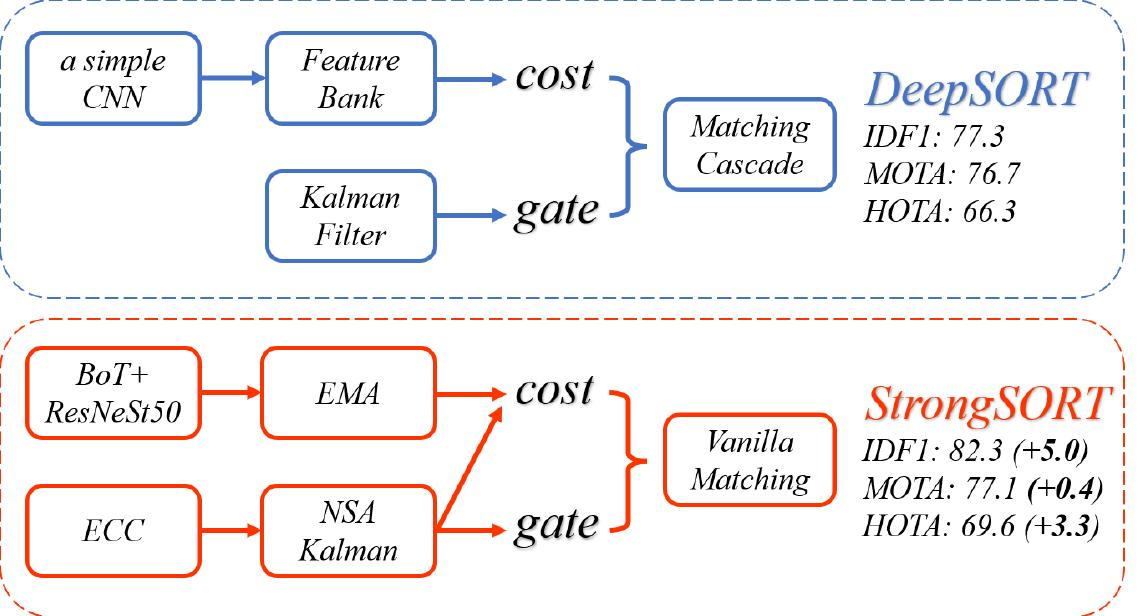

------------------------------


In [16]:
# --- Thực hiện truy vấn ---
test_queries = [
    "Compare architecture of DeepSort and StrongSort"
]

for i, query in enumerate(test_queries):
    print(f"\nUser({i+1}): {query}")
    
    # Sử dụng rag_chain_with_sources để xem cả ngữ cảnh được truy xuất
    response_obj = rag_chain_with_sources.invoke(query)
    
    print(f"AI Bot({i+1}): {response_obj['response']}")

    # Hiển thị ngữ cảnh đã truy xuất
    print("\n--- Ngữ cảnh được truy xuất ---")
    
    if response_obj['context']['texts']:
        print("\nCác đoạn văn bản/bảng:")
        i = 0
        for text_content in response_obj['context']['texts']:
            print(f"\nĐoạn {i}:")
            print(f"- {text_content[:200]}...")
            print("-" * 30)
            i += 1

    if response_obj['context']['images']:
        print("\nCác hình ảnh:")
        for img_b64 in response_obj['context']['images']:
            display_base64_image(img_b64)
            print("-" * 30)
    
    print("=" * 70)


In [17]:
import gradio as gr
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from base64 import b64decode
from PIL import Image as PILImage
import io

# --- Gemini 2.5 Flash ---
llm_main = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.3,
)

# Hàm phân loại dữ liệu (Không thay đổi)
def parse_retrieved_docs(docs):
    b64_images, text_contents = [], []
    for doc in docs:
        if doc.metadata.get("type") == "image":
            b64_images.append(doc.page_content)
        elif doc.metadata.get("type") in ["text", "table", "audio_transcript"]:
            text_contents.append(doc.page_content)
    return {"images": b64_images, "texts": text_contents}

# Hàm build prompt (Không thay đổi, đã được sửa lỗi)
def build_multimodal_prompt(kwargs):
    docs_by_type, user_question = kwargs["context"], kwargs["question"]
    context_text = "\n\n".join(docs_by_type["texts"]) if docs_by_type["texts"] else ""
    prompt_content = []
    if context_text:
        prompt_content.append({"type": "text", "text": f"Ngữ cảnh:\n{context_text}"})
    for image_b64 in docs_by_type["images"]:
        try:
            prompt_content.append({
                "type": "image_url",
                "image_url": f"data:image/png;base64,{image_b64}"
            })
        except Exception as e:
            print(f"Cảnh báo: Lỗi khi xử lý hình ảnh Base64 cho Gemini trong prompt: {e}")
            prompt_content.append({"type": "text", "text": "Đã truy xuất một hình ảnh nhưng không thể hiển thị."})

    prompt_content.append({"type": "text", "text": f"Câu hỏi: {user_question}"})

    system_message_content = """
    Bạn là một trợ lý AI thông minh và hữu ích.
    Hãy trả lời câu hỏi dựa trên ngữ cảnh đã cung cấp, bao gồm văn bản và hình ảnh.
    Nếu bạn không biết câu trả lời, hãy nói rằng bạn không biết, đừng cố bịa ra câu trả lời.
    **Quan trọng:** Vui lòng trả lời bằng cùng ngôn ngữ với câu hỏi của người dùng.
    """

    chat_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=system_message_content),
        HumanMessage(content=prompt_content),
    ])

    return chat_prompt.format_messages()

# --- Định nghĩa RAG Chain (Đã được điều chỉnh để khớp với luồng dữ liệu) ---
rag_chain = (
    # Bỏ RunnablePassthrough.assign(question=RunnablePassthrough()) ở đây
    # và thay vào đó, giả định đầu vào ban đầu đã là một dict chứa 'question'.

    # Bước 1: Truy xuất tài liệu ban đầu với multi_vector_retriever
    # x ở đây sẽ là dictionary đầu vào cho toàn bộ chain, chứa {'question': <câu hỏi người dùng>}
    RunnablePassthrough.assign(
        retrieved_docs=RunnableLambda(lambda x: multi_vector_retriever.invoke(x["question"]))
    )
    # Bước 2: Rerank các tài liệu đã truy xuất bằng hàm llm_rerank
    # 'x' ở đây là dictionary chứa {'question': ..., 'retrieved_docs': ...}
    .assign(
        context_docs_reranked=RunnableLambda(lambda x: llm_rerank(x["question"], x["retrieved_docs"]))
    )
    # Bước 3: Phân loại các tài liệu đã rerank thành hình ảnh và văn bản/HTML/audio
    # 'x' ở đây là dictionary chứa {'question': ..., 'retrieved_docs': ..., 'context_docs_reranked': ...}
    .assign(
        context=RunnableLambda(lambda x: parse_retrieved_docs(x["context_docs_reranked"]))
    )
    # Bước 4: Tạo phản hồi từ LLM chính (Gemini Flash)
    # 'x' ở đây là dictionary chứa {'question': ..., 'retrieved_docs': ..., 'context_docs_reranked': ..., 'context': ...}
    # build_multimodal_prompt mong đợi một dictionary có khóa 'context' và 'question',
    # mà 'x' hiện tại đã cung cấp đầy đủ.
    .assign(
        response=RunnableLambda(lambda x: llm_main.invoke(build_multimodal_prompt(x)).content)
    )
    # Bước 5: Chọn các trường cần trả về từ chain để sử dụng trong Gradio UI
    .pick(["response", "context", "question"]) # Giữ lại 'question' để đầy đủ thông tin
)

# Hàm xử lý câu hỏi cho Gradio (Đã thêm xử lý lỗi)
def query_rag(user_input, history):
    try:
        # Gọi RAG chain để lấy phản hồi và ngữ cảnh
        result = rag_chain.invoke({"question": user_input})
        
        response = result.get('response', "Xin lỗi, không thể tạo phản hồi từ mô hình.")
        
        # Lấy ngữ cảnh đã được parse (images và texts)
        context_data = result.get('context', {'images': [], 'texts': []})
        context_images = context_data.get('images', [])
        raw_context_texts = context_data.get('texts', [])
        
        # Định dạng văn bản ngữ cảnh để hiển thị dễ đọc
        formatted_context_texts = []
        if raw_context_texts:
            for i, text_content in enumerate(raw_context_texts):
                formatted_context_texts.append(f"=== Đoạn {i+1} ===\n{text_content}")
            context_texts_display = "\n\n".join(formatted_context_texts)
        else:
            context_texts_display = "Không có văn bản nào được truy xuất."

        # Chuyển đổi hình ảnh base64 sang định dạng hiển thị của Gradio
        images_display = []
        for img_b64 in context_images:
            try:
                # Gradio Gallery có thể hiển thị trực tiếp base64 string
                # nhưng để kiểm soát tốt hơn và debug, chúng ta có thể chuyển đổi sang PIL Image
                img = PILImage.open(io.BytesIO(b64decode(img_b64)))
                images_display.append(img)
            except Exception as e:
                print(f"Lỗi khi hiển thị hình ảnh base64: {e}")
                # Có thể thêm một hình ảnh placeholder nếu bạn muốn hiển thị lỗi trong UI
                pass

    except Exception as e:
        # Xử lý lỗi nếu RAG chain gặp vấn đề
        response = f"Đã xảy ra lỗi trong quá trình xử lý câu hỏi: {e}"
        context_texts_display = "Không có ngữ cảnh nào được truy xuất do lỗi."
        images_display = []
        print(f"Lỗi lớn khi gọi RAG chain: {e}")

    # Cập nhật lịch sử chat và trả về các thành phần UI
    history.append((user_input, response))
    return history, context_texts_display, images_display


In [ ]:
# --- Gradio UI ---
with gr.Blocks(title="🔍 Gemini RAG Chatbot") as demo:
    gr.Markdown("## 🤖 Gemini RAG Chatbot Đa Phương Thức")
    gr.Markdown(
        "Chào mừng bạn đến với Chatbot RAG sử dụng mô hình Gemini Flash. "
        "Bot có thể trả lời các câu hỏi của bạn dựa trên các tài liệu PDF và file âm thanh đã được xử lý."
    )

    chatbot = gr.Chatbot(height=300, label="Lịch sử Chat")
    question_input = gr.Textbox(placeholder="Nhập câu hỏi của bạn...", label="Câu hỏi của bạn")
    submit_btn = gr.Button("Gửi câu hỏi")

    with gr.Row():
        context_box = gr.Textbox(label="Ngữ cảnh văn bản đã truy xuất", lines=10, interactive=False)
        image_gallery = gr.Gallery(label="Hình ảnh đã truy xuất", columns=2, height="auto", interactive=False)

    # Xử lý sự kiện khi nhấn nút Gửi
    submit_btn.click(
        fn=query_rag,
        inputs=[question_input, chatbot],
        outputs=[chatbot, context_box, image_gallery],
        queue=False # Đặt False để xử lý ngay, hoặc True nếu bạn muốn hàng đợi cho nhiều yêu cầu
    ).then(
        lambda: "", # Xóa ô nhập liệu sau khi gửi
        inputs=None,
        outputs=question_input,
    )

    # Cho phép gửi câu hỏi bằng phím Enter
    question_input.submit(
        fn=query_rag,
        inputs=[question_input, chatbot],
        outputs=[chatbot, context_box, image_gallery],
        queue=False
    ).then(
        lambda: "", # Xóa ô nhập liệu sau khi gửi
        inputs=None,
        outputs=question_input,
    )

demo.launch()


# Compare architecture of DeepSort and StrongSort?
# StrongSort tracking technique test results on DanceTrack dataset?
# What are the challenges facing the planet?
# Thành phố Hồ chí Minh có những gì?


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16828\1677522287.py:9: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=300, label="Lịch sử Chat")


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised RetryError: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:74.125.68.95:443: socket is null.


Lỗi lớn khi gọi RAG chain: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:74.125.68.95:443: socket is null
Lỗi lớn khi gọi RAG chain: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:74.125.68.95:443: socket is null


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised RetryError: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:74.125.68.95:443: socket is null.


Lỗi lớn khi gọi RAG chain: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:74.125.68.95:443: socket is null
Lỗi lớn khi gọi RAG chain: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:74.125.68.95:443: socket is null
